In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

from classes.classes import ColorManager
from classes.classes import ScaledPostgresModelConfig, FlatModelConfig, E2EModelConfig, MSCNModelConfig, \
    ZeroShotModelConfig, DACEModelConfig, QueryFormerModelConfig
from classes.paths import LocalPaths
from classes.workloads import EvalWorkloads
from evaluation.evaluation_metrics import QError, RMSE
from evaluation.evaluation_metrics import SelectedRuntime
from evaluation.utils import get_model_results, draw_metric, draw_predictions
from sklearn.metrics import f1_score
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid", font_scale=1)
fontsize = 14

### General settings

In [29]:
from classes.classes import FlatModelActCardModelConfig, ZeroShotModelActCardConfig, DACEModelActCardConfig, \
    QPPNetModelConfig, QPPModelActCardsConfig

model_configs = [
    ScaledPostgresModelConfig(),
    FlatModelConfig(),
    MSCNModelConfig(),
    E2EModelConfig(),
    ZeroShotModelConfig(),
    QPPNetModelConfig(),
    QueryFormerModelConfig(),
    DACEModelConfig(),
]

act_card_model_configs = [
    ScaledPostgresModelConfig(),
    FlatModelActCardModelConfig(),
    ZeroShotModelActCardConfig(),
    QPPModelActCardsConfig(),
    DACEModelActCardConfig()
]

### Old Anecdotal Plots


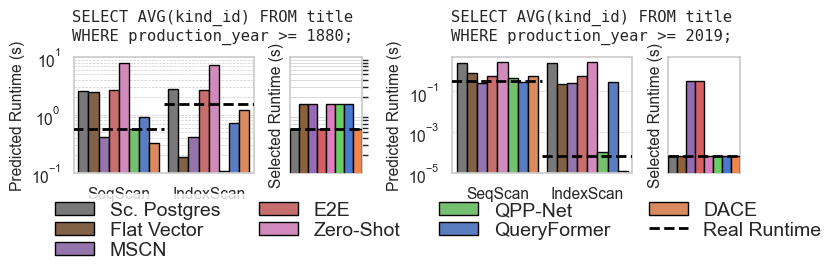

In [4]:
# General settings
path = LocalPaths().data / "plots" / "scan_costs_anecdote.pdf"
mosaic = """AAAABB\nAAAABB\nAAAABB"""
indexes = [0, 10]
titles = ["SELECT AVG(kind_id) FROM title\nWHERE production_year >= 1880;", "SELECT AVG(kind_id) FROM title\nWHERE production_year >= 2019;"]
palette = ColorManager.COLOR_PALETTE

# Generate plot
fig = plt.figure(figsize=(7.5 , 1.5), dpi=100)
figures = fig.subfigures(nrows=1, ncols=2, wspace=0.02, hspace=-0.05)

seq_results = get_model_results(EvalWorkloads.ScanCostsPercentile.imdb_seq[2], model_configs)
index_results = get_model_results(EvalWorkloads.ScanCostsPercentile.imdb_idx[2], model_configs)

for index, title, figure in zip(indexes, titles, figures):
    seq_res = seq_results[seq_results['query_index'] == index].assign(query_index="SeqScan")
    idx_res = index_results[index_results['query_index'] == index].assign(query_index="IndexScan")
    results = pd.concat([seq_res, idx_res], ignore_index=True)
    results = results.sort_values(by='model', key=lambda x: x.map({model.name.DISPLAY_NAME: i for i, model in enumerate(model_configs)}))
    figure.suptitle(t=title, fontsize=fontsize * 0.8, fontproperties={'family':'monospace'}, y=1.2, horizontalalignment='center')
    prediction_ax, runtime_ax = figure.subplot_mosaic(mosaic, gridspec_kw={'height_ratios': [1, 1, 1], 'wspace': 2, 'hspace': 0.1}).values()
    
    # Draw predictions
    seaborn.barplot(x="query_index",
                    hue="model",
                    y="prediction",
                    data=results,
                    ax=prediction_ax,
                    palette=palette,
                    errorbar=None,
                    edgecolor='black',
                    width=0.9)
    
    # Draw min label
    min_labels = [(i, results[results['query_index'] == query_index]['label'].min()) 
              for i, query_index in enumerate(results['query_index'].unique())]
    for i, min_label in min_labels:
        prediction_ax.axhline(y=min_label, xmin=i - 0.5, xmax=i + 0.5, linestyle='--', color='black', linewidth=2, zorder=100)
    
    # Prediction settings
    prediction_ax.set_xlabel("")
    prediction_ax.set_ylabel("Predicted Runtime (s)", fontsize=fontsize * 0.8)
    prediction_ax.grid(axis="y", which='both', linestyle='--', linewidth=0.5)
    prediction_ax.set_yscale('log')
    prediction_ax.tick_params(axis='x', rotation=0, labelsize=fontsize * 0.8)
    prediction_ax.tick_params(axis='y', rotation=0, labelsize=fontsize * 0.8)
    
    # Draw selected runtime    
    draw_metric(results, model_configs, runtime_ax, SelectedRuntime(), fontsize=fontsize)
    runtime_ax.axhline(y=results['runtime'].min(), linestyle='--', color='black', linewidth=2, zorder=100)
    runtime_ax.set_yscale('log')
    runtime_ax.set_yticks([])
    
    if index == 0:
        prediction_ax.set_ylim(0.1, 10)
        runtime_ax.set_ylim(0.1, 10)
        handles, labels = prediction_ax.get_legend_handles_labels()
        handles.append(Line2D([0], [0], color='black', lw=2, linestyle='--', label='Real Runtime'))
        legend = prediction_ax.legend(handles=handles, 
                                      fontsize=fontsize,
                                      ncol=4,
                                      loc='center left',
                                      bbox_to_anchor=(-0.2, -0.5),
                                      labelspacing=0.1,
                                      edgecolor='white')
    else:
        prediction_ax.set_ylim(1e-5, 5)
        runtime_ax.set_ylim(1e-5, 5)
        prediction_ax.get_legend().remove()

fig.align_labels()
fig.savefig(path, bbox_inches='tight')

### New Anecdotal Plots

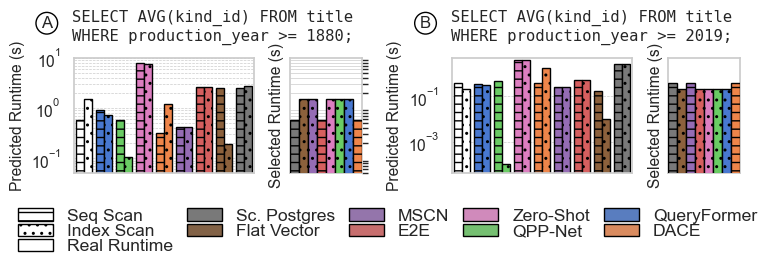

In [13]:
path = LocalPaths().data / "plots" / "scan_costs_anecdote.pdf"
mosaic = """AAAABB\nAAAABB\nAAAABB"""
indexes = [0, 9]
titles = ["SELECT AVG(kind_id) FROM title\nWHERE production_year >= 1880;", "SELECT AVG(kind_id) FROM title\nWHERE production_year >= 2019;"]
palette = ColorManager.COLOR_PALETTE
hatch_patterns = {"SeqScan": "--", "IndexScan": ".."}

# Generate plot
fig = plt.figure(figsize=(7.5 , 1.5), dpi=100)
figures = fig.subfigures(nrows=1, ncols=2, wspace=0.02, hspace=-0.05)

seq_results = get_model_results(EvalWorkloads.ScanCostsPercentile.imdb_seq[2], model_configs)
index_results = get_model_results(EvalWorkloads.ScanCostsPercentile.imdb_idx[2], model_configs)

for index, title, figure in zip(indexes, titles, figures):
    seq_res = seq_results[seq_results['query_index'] == index].assign(query_index="SeqScan")
    idx_res = index_results[index_results['query_index'] == index].assign(query_index="IndexScan")
    results = pd.concat([seq_res, idx_res], ignore_index=True)
    
    # Add a new model which displays the real runtime
    real_runtime = results.groupby("query_index")["runtime"].min().reset_index()
    real_runtime["model"] = "Real Runtime"
    real_runtime["prediction"] = real_runtime["runtime"]
    real_runtime["label"] = real_runtime["runtime"]
    real_runtime["runtime"] = real_runtime["runtime"]
    real_runtime["selected_runtime"] = real_runtime["runtime"]
    
    results = pd.concat([results, real_runtime], ignore_index=True)
    sort_map = {model.name.DISPLAY_NAME: i for i, model in enumerate(model_configs)}
    sort_map["Real Runtime"] = -1
    results = results.sort_values(by='model', key=lambda x: x.map(sort_map))
    
    results = results.sort_values(by='query_index', key=lambda x: x.map({"SeqScan": 0, "IndexScan": 1}))
    figure.suptitle(t=title, fontsize=fontsize * 0.8, fontproperties={'family':'monospace'}, y=1.2, horizontalalignment='center')
    prediction_ax, runtime_ax = figure.subplot_mosaic(mosaic, gridspec_kw={'height_ratios': [1, 1, 1], 'wspace': 2, 'hspace': 0.1}).values()

    # Draw predictions
    bars = seaborn.barplot(x="model",
                    hue="query_index",
                    y="prediction",
                    data=results,
                    ax=prediction_ax,
                    #palette=color_mapping,
                    errorbar=None,
                    edgecolor='black',
                    width=0.8)
    
    bar_groups = []
    for bar, label in zip(bars.patches, bars.get_xticklabels() + bars.get_xticklabels()):
        row = {"x": bar.get_x(), "model":  label.get_text(), "bar": bar}
        bar_groups.append(row)
    
    # Sort bar groups by x position
    bar_groups = sorted(bar_groups, key=lambda x: x['x'])
    
    # Set background color for each group of bars (grouped by model)
    for bar_group in bar_groups:
        color = ColorManager.COLOR_PALETTE.get(bar_group["model"], 'white')
        bar_group["bar"].set_facecolor(color)
        

    # Apply hatch patterns
    for bar, workload_type in zip(bars.patches, results['query_index']):
        bar.set_hatch(hatch_patterns[workload_type])

    
    # Prediction settings
    prediction_ax.set_xlabel("")
    prediction_ax.set_ylabel("Predicted Runtime (s)", fontsize=fontsize * 0.8)
    prediction_ax.grid(axis="y", which='both', linestyle='--', linewidth=0.5)
    prediction_ax.set_yscale('log')
    prediction_ax.tick_params(axis='x', rotation=45, labelsize=fontsize * 0.8, pad=-4)
    prediction_ax.tick_params(axis='y', rotation=0, labelsize=fontsize * 0.8,)
    prediction_ax.set_xticklabels([])    
    prediction_ax.get_legend().remove()
    
    for tick in prediction_ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
        tick.set_verticalalignment("top")

    
    # Draw selected runtime    
    draw_metric(results, model_configs, runtime_ax, SelectedRuntime(), fontsize=fontsize)
    #runtime_ax.axhline(y=results['runtime'].min(), linestyle='--', color='black', linewidth=2, zorder=100)
    runtime_ax.set_yscale('log')
    runtime_ax.set_yticks([])
    
    # Add circeld letter to the top left corner to disinguish plots
    letter = "A" if index == 0 else "B"
    prediction_ax.annotate(
            letter,
            xy=(-0.15, 1.30), 
            xycoords='axes fraction', 
            fontsize=12, 
            ha='center', 
            va='center', 
            bbox=dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white'))
    for bar in runtime_ax.patches:
        y = bar.get_height()
        if y == results[results['query_index'] == "SeqScan"]['runtime'].min():
            bar.set_hatch(hatch_patterns["SeqScan"])
        else:
            bar.set_hatch(hatch_patterns["IndexScan"])
    
    
    if index == 0:
        prediction_ax.set_ylim(0.05, 10)
        runtime_ax.set_ylim(0.05, 10)
        handles, labels = runtime_ax.get_legend_handles_labels()
        #handles = []
        
        for handle in handles:
            handle.set_hatch(None)
        # Add a new rectangle to the legend
        new_rectangle = Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Real Runtime')
        handles.insert(0, new_rectangle)
        
        new_rectangle = Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Index Scan')
        new_rectangle.set_hatch(hatch_patterns["IndexScan"])
        handles.insert(0, new_rectangle)
        
        new_rectangle = Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Seq Scan')
        new_rectangle.set_hatch(hatch_patterns["SeqScan"])
        handles.insert(0, new_rectangle)
        
        legend = runtime_ax.legend(handles=handles, 
                                      fontsize=fontsize*0.9,
                                      ncol=5,
                                      loc='center left',
                                      bbox_to_anchor=(-4, -0.5),
                                      labelspacing=0.0,
                                      columnspacing=0.8,
                                      edgecolor='white')
    else:
        prediction_ax.set_ylim(4e-5, 5)
        runtime_ax.set_ylim(4e-5, 5)
    

fig.align_labels()
fig.savefig(path, bbox_inches='tight')

### Depreccated: Plots over attribute range

In [ ]:
mosaic = """AAAABB\nAAAACC\nAAAADD"""
paths = [LocalPaths().data / "plots" / "scan_cost_examples_pred.pdf", LocalPaths().data / "plots" / "scan_cost_examples_card.pdf"]
gridspecs = {'height_ratios': [1, 1, 1], 'wspace': 30, 'hspace': 0.15}
workloads = [EvalWorkloads.ScanCostsPercentile.imdb_seq[0], EvalWorkloads.ScanCostsPercentile.imdb_idx[0]]

for x_index, path in zip(["query_index", "act_card"], paths):
    fig = plt.figure(figsize=(8, 2.5), dpi=100)
    figures = fig.subfigures(nrows=1, ncols=2, wspace=-0.0, hspace=-0.05)
    
    for idx, (workload, figure) in enumerate(zip(workloads, figures)):
        results = get_model_results(workload, model_configs)    
        if x_index == "query_index":
            # Scale query index to the range of the workload
            xrange = workload.get_y_range()
            results['query_index'] = results['query_index'] / (len(results['query_index'].unique()) - 1) * (max(xrange) - min(xrange)) + min(xrange)
        
        prediction_ax, qerror_ax, spearmans, runtime_ax = figure.subplot_mosaic(mosaic, gridspec_kw=gridspecs).values()
        handles, labels = draw_predictions(workload, results, model_configs, prediction_ax, fontsize, x_index=x_index, plot_cardinality=x_index=="act_card")
        draw_metric(results, model_configs, qerror_ax, QError(), fontsize)
        draw_metric(results, model_configs, spearmans, RMSE(), fontsize)
        draw_metric(results, model_configs, runtime_ax, SelectedRuntime(), fontsize)
        
        if x_index == "query_index":
            prediction_ax.set_xlim(min(xrange), max(xrange))
            prediction_ax.set_xlabel("Production Year")
        else: 
            prediction_ax.set_xlabel("Selectivity")
        prediction_ax.set_ylim(1e-3, 10)
        prediction_ax.legend(fontsize=8, ncol=2, loc='upper left')
        prediction_ax.get_legend().remove()
        qerror_ax.set_ylim(1, 10)
        runtime_ax.set_yscale('log')
        runtime_ax.set_ylim(1e-5, 1)
    
        if idx == 0:
            prediction_ax.set_ylabel('Runtime (s)', fontsize=fontsize)
            prediction_ax.legend(handles=handles, labels=labels, fontsize=8, ncol=2, loc='lower left')
            prediction_ax.set_title("Sequential Scan", fontsize=fontsize)
        else:
            prediction_ax.set_ylabel('')
            prediction_ax.set_title("Index Scan", fontsize=fontsize)
    
    fig.align_labels()
    fig.savefig(path,  bbox_inches='tight')

### Plots over selectivity range

seq.cast_info.movie_id
Breaking point at: 0.20000072287140858
Postgres
6     seq
14    seq
22    seq
30    seq
38    seq
46    seq
54    seq
62    seq
70    seq
78    idx
Name: predicted_operator, dtype: object
QPPNet
4     seq
12    seq
20    seq
28    seq
36    seq
44    seq
52    seq
60    seq
68    idx
76    idx
Name: predicted_operator, dtype: object
4     seq
12    seq
20    seq
28    seq
36    seq
44    seq
52    seq
60    seq
68    idx
76    idx
Name: optimal_operator, dtype: object


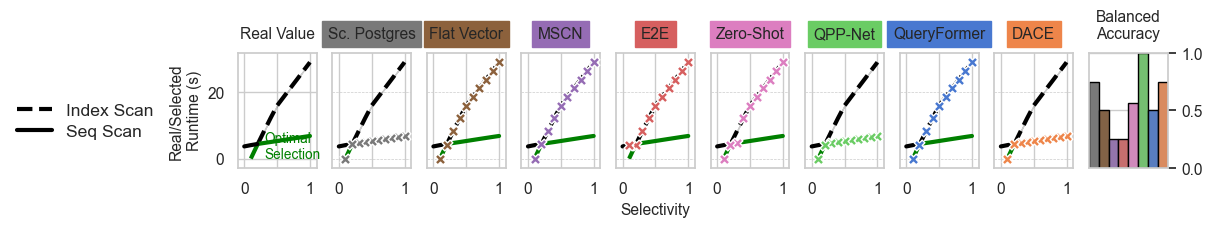

In [42]:
label_encoder = LabelEncoder()
path = LocalPaths().data / "plots" / "scan_costs_over_column.pdf"
mosaic = """AAAABB\nAAAACC\nAAAADD"""

#seq_workloads, idx_workloads = EvalWorkloads.ScanCostsPercentile.baseball_seq, EvalWorkloads.ScanCostsPercentile.baseball_idx
#seq_workloads, idx_workloads = EvalWorkloads.ScanCostsPercentile.tpc_h_pk_seq, EvalWorkloads.ScanCostsPercentile.tpc_h_pk_idx
seq_workloads, idx_workloads = EvalWorkloads.ScanCostsPercentile.imdb_seq, EvalWorkloads.ScanCostsPercentile.imdb_idx

acc_dataframes = []

for seq_workload, idx_workload in zip(seq_workloads[4:5], idx_workloads[4:5]):
    # Get and rename results
    seq_results = get_model_results(seq_workload, model_configs).rename(columns={'prediction': 'prediction_seq', 'label': 'label_seq'})
    idx_results = get_model_results(idx_workload, model_configs).rename(columns={'prediction': 'prediction_idx', 'label': 'label_idx'})
    results = pd.concat([seq_results, idx_results[['prediction_idx', 'label_idx']]], axis=1)
    
    # New: Remove slightly deviating query labels:
    results['label_idx'] = results.groupby('query_index')['label_idx'].transform('last')
    results['label_seq'] = results.groupby('query_index')['label_seq'].transform('last')
    
    # Assign optimal and predicted operators
    results = results.assign(
        optimal_operator=np.where(results['label_idx'] < results['label_seq'], 'idx', 'seq'),
        predicted_operator=np.where(results['prediction_idx'] < results['prediction_seq'], 'idx', 'seq'))
    

    
    # Give the index of the query where the label difference between idx and seq is minimal
    min_diff_idx = (results['label_idx'] - results['label_seq']).abs().idxmin()
    max_label = max(results['label_idx'].max(), results['label_seq'].max())
    
    # Print the selectivity of the query where the difference is minimal
    print(seq_workload.get_workload_name())
    print(f"Breaking point at: {results.loc[min_diff_idx, 'act_card'] / max(results['act_card'])}")
    
    # Create selected_runtime column
    results['selected_runtime'] = np.where(results['prediction_idx'] < results['prediction_seq'], results['label_idx'], results['label_seq'])
    
    # Scale act_card and calculate accuracy
    results['act_card'] = (results['act_card'] - results['act_card'].min()) / (results['act_card'].max() - results['act_card'].min())
    #results['accuracy'] = (results['optimal_operator'] == results['predicted_operator']).astype(int)
    #results['accuracy'] = balanced_accuracy_score(results['optimal_operator'], results['predicted_operator'])
    results.loc[:, 'predicted_operator_encoded'] = label_encoder.fit_transform(results['predicted_operator'])
    results.loc[:, 'optimal_operator_encoded'] = label_encoder.fit_transform(results['optimal_operator'])

    fig, axs = plt.subplots(1, len(model_configs) + 2, figsize=(12, 1.5), dpi=100, sharey=False)
    x_index = "act_card"
        
    real_value_ax = axs[0]
    prediction_axs = axs[1:-1]
    accuracy_ax = axs[-1]
    balanced_accuracy_scores = []
    f1_scores = []
    
    for model, prediction_ax in zip(model_configs, prediction_axs):
        model_results = results[results['model'] == model.name.DISPLAY_NAME]
        
        # Delete rows that contain NaN values (which happens for timeouts)
        model_results = model_results.dropna()
    
        # Calculate balanced accuracy
        if model == QPPNetModelConfig():
            print("QPPNet")
            print(model_results["predicted_operator"])
            print(model_results["optimal_operator"])
        if model == ScaledPostgresModelConfig():
            print("Postgres")
            print(model_results["predicted_operator"])
        
        accuracy = balanced_accuracy_score(model_results["optimal_operator"], model_results["predicted_operator"])
        balanced_accuracy_scores.append((model.name.DISPLAY_NAME, accuracy))
        # Plot optimal sequential runtimes
        seaborn.lineplot(x=x_index,
                         y="label_seq",
                         linestyle="solid",
                         ax=prediction_ax,
                         data=model_results[model_results.index < min_diff_idx],
                         label="Seq Runtime",
                         color="green",
                         #linewidth=2,
                         zorder=100)
        
        # Plot optimal index runtimes
        seaborn.lineplot(x=x_index,
                         y="label_idx",
                         linestyle="dotted",
                         ax=prediction_ax,
                         data=model_results[model_results.index >= min_diff_idx],
                         label="Index Runtime",
                         color="green",
                         #linewidth=2,
                         zorder=100)
        
        # Plot selected runtimes from the model
        seaborn.scatterplot(x=x_index,
                         y="selected_runtime",
                         data=model_results,
                         ax=prediction_ax,
                         label=model.name.DISPLAY_NAME,
                         color=model.color(),
                         s=60,
                         linewidth=1,
                         marker="X",
                         zorder=110)
        
        seaborn.lineplot(x=x_index, y="label_idx", linestyle="dashed", ax=prediction_ax, data=results[results.index >= min_diff_idx], label=None, color="green", zorder=100, linewidth=3)
        seaborn.lineplot(x=x_index, y="label_idx", linestyle="dashed", ax=prediction_ax, data=results[results.index <= min_diff_idx], label=None, color="black", zorder=100, linewidth=3)
        seaborn.lineplot(x=x_index, y="label_seq", linestyle="solid", ax=prediction_ax, data=results[results.index <= min_diff_idx], label=None, color="green",zorder=100, linewidth=3)
        seaborn.lineplot(x=x_index, y="label_seq", linestyle="solid", ax=prediction_ax, data=results[results.index >= min_diff_idx], label=None, color="black",  zorder=100, linewidth=3)
    
        
        # Plot settings
        prediction_ax.set_xlabel("")
        prediction_ax.set_ylabel("")
        prediction_ax.tick_params(axis='x', rotation=0, labelsize=fontsize * 0.8)
        prediction_ax.tick_params(axis='y', rotation=0, labelsize=fontsize * 0.8)
        prediction_ax.set_ylim(max_label * -0.1 , max_label * 1.1)
        prediction_ax.set_xlim(-0.1, 1.1)
        prediction_ax.set_title(model.name.DISPLAY_NAME, fontsize=fontsize * 0.8, backgroundcolor=model.color(), y=1.05)
        prediction_ax.set_xticks([0, 0.5, 1], labels=[0, "", 1])
        prediction_ax.set_yticklabels([])
        prediction_ax.grid(axis="y", which='both', linestyle='--', linewidth=0.5)
        prediction_ax.get_legend().remove()
    

    # Plot accuracies
    accuracy_df = pd.DataFrame(balanced_accuracy_scores, columns=['model', 'accuracy'])
    seaborn.barplot(x="model",
                    y="accuracy",
                    hue="model",
                    data=accuracy_df,
                    ax=accuracy_ax,
                    palette=ColorManager.COLOR_PALETTE,
                    errorbar=None,
                    order=[model.name.DISPLAY_NAME for model in model_configs],
                    width=1,
                    edgecolor='black')
    
    accuracy_ax.set_xlabel("")
    accuracy_ax.set_xticks([])    
    accuracy_ax.set_ylabel("Accuracy", fontsize=fontsize * 0.8)
    accuracy_ax.set_ylim(0, 1)
    accuracy_ax.yaxis.tick_right()
    accuracy_ax.tick_params(axis='x', rotation=0, labelsize=fontsize * 0.8, size=0)
    accuracy_ax.tick_params(axis='y', rotation=0, labelsize=fontsize * 0.8)
    accuracy_ax.set_ylabel("")
    accuracy_ax.set_title("Balanced\nAccuracy", fontsize=fontsize * 0.8, backgroundcolor='white', y=1.05)

    # Add selectivity label        
    prediction_axs[3].set_xlabel("Selectivity", fontsize=fontsize * 0.8)
    
    seaborn.lineplot(x=x_index, y="label_idx", linestyle="dashed", ax=real_value_ax, data=results[results.index >= min_diff_idx], label=None, color="green", zorder=100, linewidth=3)
    seaborn.lineplot(x=x_index, y="label_idx", linestyle="dashed", ax=real_value_ax, data=results[results.index <= min_diff_idx], label="Index Scan", color="black", zorder=100, linewidth=3)
    seaborn.lineplot(x=x_index, y="label_seq", linestyle="solid", ax=real_value_ax, data=results[results.index <= min_diff_idx], label=None, color="green",zorder=100, linewidth=3)
    seaborn.lineplot(x=x_index, y="label_seq", linestyle="solid", ax=real_value_ax, data=results[results.index >= min_diff_idx], label="Seq Scan", color="black",  zorder=100, linewidth=3)
    
    real_value_ax.set_xlabel("", fontsize=fontsize)
    real_value_ax.set_xticks([0, 0.5, 1], labels=[0, "", 1])
    real_value_ax.set_xlim(-0.1,   1.1)
    real_value_ax.set_ylim(max_label * -0.1,  max_label * 1.1)
    real_value_ax.set_ylabel("Real/Selected\nRuntime (s)", fontsize=fontsize * 0.8)
    real_value_ax.tick_params(axis='x', rotation=0, labelsize=fontsize * 0.8)
    real_value_ax.tick_params(axis='y', rotation=0, labelsize=fontsize * 0.8)
    real_value_ax.set_title("Real Value", fontsize=fontsize * 0.8, backgroundcolor='white', y=1.05)
    real_value_ax.annotate('Optimal\nSelection', xy=(0.3, 0.01), xytext=(0.3, 0.01), fontsize=fontsize * 0.7, color='green')
    real_value_ax.legend(fontsize=fontsize * 0.9, ncol=1, loc='upper left', bbox_to_anchor=(-3, 0.7), labelspacing=0.3, edgecolor='white')
    
    fig.align_labels()
    plt.subplots_adjust(wspace=0.2)
    if seq_workload.get_workload_name() == "seq.title.production_year":
        fig.savefig(path, bbox_inches='tight')
    plt.show()

In [44]:
results[results['model'] == "Sc. Postgres"]

,model,query_index,label_seq,prediction_seq,runtime,act_card,est_card,prediction_idx,label_idx,optimal_operator,predicted_operator,q_error,accuracy
6,Sc. Postgres,0,0.242781,2.596122,0.242781,1.000000,799921.0,2.714338,0.773047,seq,seq,1.000099,0.567708
14,Sc. Postgres,1,0.237678,2.596122,0.237678,0.900003,720730.0,2.710245,0.692461,seq,seq,1.001010,0.567708
22,Sc. Postgres,2,0.232461,2.596122,0.232461,0.800006,642168.0,2.706182,0.616623,seq,seq,1.003378,0.567708
30,Sc. Postgres,3,0.227291,2.596122,0.227291,0.700004,561444.0,2.702014,0.541236,seq,seq,1.002570,0.567708
38,Sc. Postgres,4,0.222340,2.596122,0.222340,0.600001,481921.0,2.697898,0.463848,seq,seq,1.003996,0.567708
46,Sc. Postgres,5,0.216965,2.596122,0.216965,0.500006,401355.0,2.693735,0.389633,seq,seq,1.003367,0.567708
54,Sc. Postgres,6,0.209795,2.596122,0.209795,0.399999,319977.0,2.689532,0.312989,seq,seq,1.000081,0.567708
62,Sc. Postgres,7,0.201194,2.596122,0.201194,0.300002,239871.0,2.685390,0.236938,seq,seq,1.000563,0.567708
70,Sc. Postgres,8,0.192851,2.596122,0.192851,0.200000,158741.0,2.681195,0.160963,idx,seq,1.007963,0.567708
78,Sc. Postgres,9,0.185030,2.596122,0.185030,0.099993,79735.0,2.677110,0.084053,idx,seq,1.003324,0.567708


### Results over multiple workloads and columns

In [45]:
workload_pairs = [
    (EvalWorkloads.ScanCostsPercentile.imdb_seq, EvalWorkloads.ScanCostsPercentile.imdb_idx),
    (EvalWorkloads.ScanCostsPercentile.baseball_seq, EvalWorkloads.ScanCostsPercentile.baseball_idx),
    (EvalWorkloads.ScanCostsPercentile.tpc_h_pk_seq, EvalWorkloads.ScanCostsPercentile.tpc_h_pk_idx)]

accuracies = []

for (seq, idx) in workload_pairs:
    
    for (seq_workload, idx_workload) in zip(seq, idx):
        seq_results = get_model_results(seq_workload, model_configs).rename(columns={'prediction': 'prediction_seq', 'label': 'label_seq'})
        idx_results = get_model_results(idx_workload, model_configs).rename(columns={'prediction': 'prediction_idx', 'label': 'label_idx'})
        results = pd.concat([seq_results, idx_results[['prediction_idx', 'label_idx']]], axis=1)
        
        # New: Remove slightly deviating query labels:
        results['label_idx'] = results.groupby('query_index')['label_idx'].transform('first')
        results['label_seq'] = results.groupby('query_index')['label_seq'].transform('first')
    
        results = results.assign(
            optimal_operator=np.where(results['label_idx'] < results['label_seq'], 'idx', 'seq'),
            predicted_operator=np.where(results['prediction_idx'] < results['prediction_seq'], 'idx', 'seq'))
            
        # Give the index of the query where the label difference between idx and seq is minimal
        min_diff_idx = (results['label_idx'] - results['label_seq']).abs().idxmin()
        
        # Print the selectivity of the query where the difference is minimal
        #print(f"Breaking point at: {results.loc[min_diff_idx, 'act_card'] / max(results['act_card'])}")
        
        # Compute q-error of cardinalities as well:
        results['q_error'] = results.apply(lambda row: max(row['act_card'], row['est_card']) / min(row['act_card'], row['est_card']) if row['est_card'] != 0 and row['act_card'] != 0 else np.nan, axis=1)
        
        # Scale act_card and calculate accuracy
        results['act_card'] = (results['act_card'] - results['act_card'].min()) / (results['act_card'].max() - results['act_card'].min())
        results['accuracy'] = (results['optimal_operator'] == results['predicted_operator']).astype(int)
        results['accuracy'] = balanced_accuracy_score(results['optimal_operator'], results['predicted_operator'])
        

        # Calculate the accuracy for each model
        accuracy = results.groupby("model")["accuracy"].mean()
        
        balanced_accuracy_scores = []
        for model in model_configs:
            model_results = results[results['model'] == model.name.DISPLAY_NAME]
                    
            # Delete rows that contain NaN values (which happens for timeouts)
            model_results = model_results.dropna()
            
            accuracy = round(balanced_accuracy_score(model_results["optimal_operator"], model_results["predicted_operator"]), 2)
            balanced_accuracy_scores.append((model.name.DISPLAY_NAME, accuracy))
            #f1_sc = round(f1_score(model_results["optimal_operator"], model_results["predicted_operator"], average='weighted'), 2)
            #f1_scores.append((model.name.DISPLAY_NAME, f1_sc))
    
        accuracy_df = pd.DataFrame(balanced_accuracy_scores, columns=['model', 'f1']).T
        accuracy_df.columns = accuracy_df.iloc[0]
        accuracy_df.drop(accuracy_df.index[0], inplace = True)
        accuracy_df['table'] = seq_workload.table
        accuracy_df['column'] = seq_workload.column
        accuracy_df['workload'] = seq_workload.database.db_name
        accuracy_df["q_error"] = results["q_error"].median()
        accuracies.append(accuracy_df)

result = pd.concat(accuracies, axis=0)
result = result.round(2)
# Add new row for each dataset with the main accuracy

result.reset_index(drop=True, inplace=True)
result = result[["workload", "table", "column", "Sc. Postgres", "Flat Vector", "MSCN", "E2E", "Zero-Shot", "QPP-Net", "QueryFormer", "DACE", "q_error"]]
result["table"] = result["table"].str.replace("_", "\_")
result["column"] = result["column"].str.replace("_", "\_")
average =  result[["workload", "Sc. Postgres", "Flat Vector", "MSCN", "E2E", "Zero-Shot", "QPP-Net", "QueryFormer","DACE", "q_error",]].groupby("workload").mean()
average = average.astype('float64').round(2)
average["workload"] = average.index
average["table"] = None
average["column"] = None
# concat average to results
result = pd.concat([result, average], axis=0)
result.sort_values(by=["workload", "table", "column"], inplace=True)
result

model,workload,table,column,Sc. Postgres,Flat Vector,MSCN,E2E,Zero-Shot,QPP-Net,QueryFormer,DACE,q_error
6,baseball,batting,AB,0.67,0.58,0.46,0.31,0.42,0.5,1.0,0.67,1.00
7,baseball,batting,G\_batting,0.67,0.46,0.69,0.5,0.6,0.5,0.5,0.67,1.00
8,baseball,halloffame,needed,0.5,0.5,0.48,0.5,0.5,0.5,0.5,0.62,1.00
9,baseball,managers,L,0.6,0.5,0.3,0.5,0.5,0.5,0.5,0.6,1.01
10,baseball,managers,W,0.6,0.4,0.73,0.5,0.5,0.5,0.6,0.6,1.01
11,baseball,managershalf,L,0.5,0.83,0.5,0.58,0.5,0.5,0.5,0.5,1.00
12,baseball,managershalf,W,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,1.00
baseball,baseball,None,None,0.58,0.61,0.52,0.48,0.5,0.5,0.59,0.59,1.00
3,imdb,aka\_name,person\_id,0.62,0.38,0.61,0.75,0.38,0.5,0.5,0.62,1.01
4,imdb,cast\_info,movie\_id,0.75,0.5,0.25,0.25,0.56,1.0,0.5,0.75,1.00


In [46]:
total_average = result[["Sc. Postgres", "Flat Vector", "MSCN", "E2E", "Zero-Shot", "QPP-Net", "QueryFormer","DACE"]].mean()
total_average

model
Sc. Postgres    0.637083
Flat Vector     0.565833
MSCN             0.45875
E2E               0.4725
Zero-Shot         0.4575
QPP-Net         0.538333
QueryFormer     0.497917
DACE            0.638333
dtype: object

### Preference over selectivity

In [ ]:
import math

path = LocalPaths().data / "plots" / "scan_preference.pdf"

seq_workloads = EvalWorkloads.ScanCostsPercentile.imdb_seq + EvalWorkloads.ScanCostsPercentile.tpc_h_pk_seq + EvalWorkloads.ScanCostsPercentile.baseball_seq
idx_workloads = EvalWorkloads.ScanCostsPercentile.imdb_idx + EvalWorkloads.ScanCostsPercentile.tpc_h_pk_idx + EvalWorkloads.ScanCostsPercentile.baseball_idx
all_results = []

# Function to floor round to 1 decimal place
def floor_round(value):
    return math.floor(value * 10) / 10


for seq_workload, idx_workload in zip(seq_workloads, idx_workloads):
    # Get and rename results
    seq_results = get_model_results(seq_workload, model_configs).rename(columns={'prediction': 'prediction_seq', 'label': 'label_seq'})
    idx_results = get_model_results(idx_workload, model_configs).rename(columns={'prediction': 'prediction_idx', 'label': 'label_idx'})
    results = pd.concat([seq_results, idx_results[['prediction_idx', 'label_idx']]], axis=1)
    # Assign optimal and predicted operators
    results = results.assign(
        optimal_operator=np.where(results['label_idx'] < results['label_seq'], 'idx', 'seq'),
        predicted_operator=np.where(results['prediction_idx'] < results['prediction_seq'], 'idx', 'seq'))
        
    # Give the index of the query where the label difference between idx and seq is minimal
    min_diff_idx = (results['label_idx'] - results['label_seq']).abs().idxmin()
    # Normalize the cardinalities. Use rank method here. This is not fully precise, as act_card can be in between of 0.1 steps
    results['normalized_card'] = (results['act_card'].rank(method='dense') - 1)   /  10
    results['workload'] = seq_workload.get_workload_name()
    results['accuracy'] = (results['optimal_operator'] == results['predicted_operator']).astype(int)
    all_results.append(results)

total_results = pd.concat(all_results, axis=0)

# Extract predicted operator fraction
predicted_operators = total_results.groupby(["model", "normalized_card"])["predicted_operator"].value_counts().reset_index()
predicted_operators = predicted_operators[predicted_operators["predicted_operator"] == "seq"]
predicted_operators["count"] = predicted_operators["count"] / len(seq_workloads)

# Extract optimal operator fraction
optimal_operators = total_results.groupby(["model", "normalized_card"])["optimal_operator"].value_counts().reset_index()
optimal_operators = optimal_operators[optimal_operators["optimal_operator"] == "seq"]
optimal_operators["count"] = optimal_operators["count"] / len(seq_workloads)
optimal_operators = optimal_operators[optimal_operators["model"] == "DACE"]

x = "normalized_card"
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
seaborn.lineplot(x=x, y="count", hue="model", data=predicted_operators, ax=ax, palette=ColorManager.COLOR_PALETTE)
seaborn.scatterplot(x=x, y="count", hue="model", data=predicted_operators, ax=ax, palette=ColorManager.COLOR_PALETTE, legend=False, marker="X", s=100)
seaborn.lineplot(x=x, y="count", data=optimal_operators, ax=ax, color="black")
seaborn.scatterplot(x=x, y="count", data=optimal_operators, ax=ax, color="black", legend=False, marker="o", s=100, label="Optimal")

ax.set_ylabel("Ratio of Sequential Scans", fontsize=fontsize)
ax.set_xlabel("Selectivity", fontsize=fontsize)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

# Create legend
legend_patches = [mpatches.Patch(color=model_config.color(), label=model_config.name.DISPLAY_NAME) for model_config in model_configs]

legend_patches.append(mpatches.Patch(color="black", label="Optimal Selection"))
for p in legend_patches:
    p.set_edgecolor('black')
    
ax.legend(handles=legend_patches, 
           loc='center right', 
           bbox_to_anchor=(-0.2, 0.5), 
           edgecolor='white', 
           labelspacing=0.2, 
           fontsize=fontsize)
    
fig.align_labels()
plt.subplots_adjust(wspace=0.2)
fig.savefig(path, bbox_inches='tight')
plt.show()

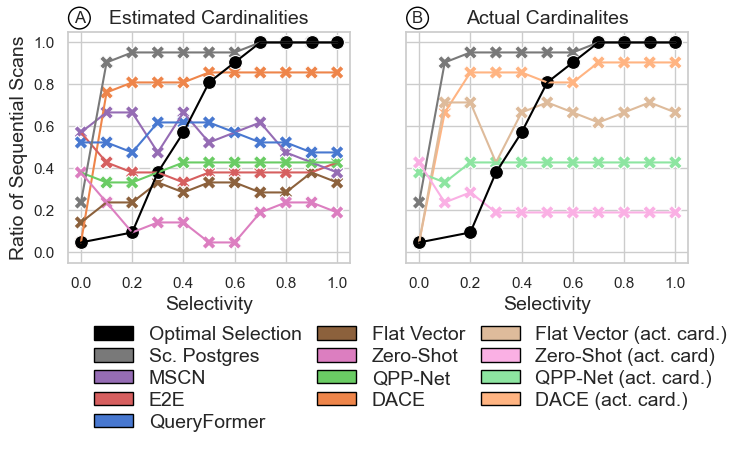

In [55]:
import math

path = LocalPaths().data / "plots" / "scan_preference.pdf"
seq_workloads = EvalWorkloads.ScanCostsPercentile.imdb_seq + EvalWorkloads.ScanCostsPercentile.tpc_h_pk_seq + EvalWorkloads.ScanCostsPercentile.baseball_seq
idx_workloads = EvalWorkloads.ScanCostsPercentile.imdb_idx + EvalWorkloads.ScanCostsPercentile.tpc_h_pk_idx + EvalWorkloads.ScanCostsPercentile.baseball_idx

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100, sharey=True)

for model_conf, ax in zip([model_configs, act_card_model_configs], axs):
    all_results = []
    for seq_workload, idx_workload in zip(seq_workloads, idx_workloads):
        # Get and rename results
        seq_results = get_model_results(seq_workload, model_conf).rename(columns={'prediction': 'prediction_seq', 'label': 'label_seq'})
        idx_results = get_model_results(idx_workload, model_conf).rename(columns={'prediction': 'prediction_idx', 'label': 'label_idx'})
        results = pd.concat([seq_results, idx_results[['prediction_idx', 'label_idx']]], axis=1)
        # Assign optimal and predicted operators
        results = results.assign(
            optimal_operator=np.where(results['label_idx'] < results['label_seq'], 'idx', 'seq'),
            predicted_operator=np.where(results['prediction_idx'] < results['prediction_seq'], 'idx', 'seq'))
            
        # Give the index of the query where the label difference between idx and seq is minimal
        min_diff_idx = (results['label_idx'] - results['label_seq']).abs().idxmin()
        # Normalize the cardinalities. Use rank method here. This is not fully precise, as act_card can be in between of 0.1 steps
        results['normalized_card'] = (results['act_card'].rank(method='dense') - 1)   /  10
        results['workload'] = seq_workload.get_workload_name()
        results['accuracy'] = (results['optimal_operator'] == results['predicted_operator']).astype(int)
        all_results.append(results)
    
    total_results = pd.concat(all_results, axis=0)
    
    # Extract predicted operator fraction
    predicted_operators = total_results.groupby(["model", "normalized_card"])["predicted_operator"].value_counts().reset_index()
    predicted_operators = predicted_operators[predicted_operators["predicted_operator"] == "seq"]
    predicted_operators["count"] = predicted_operators["count"] / len(seq_workloads)
    
    # Extract optimal operator fraction
    optimal_operators = total_results.groupby(["model", "normalized_card"])["optimal_operator"].value_counts().reset_index()
    optimal_operators = optimal_operators[optimal_operators["optimal_operator"] == "seq"]
    optimal_operators["count"] = optimal_operators["count"] / len(seq_workloads)
    optimal_operators = optimal_operators[optimal_operators["model"] == "Sc. Postgres"]
    
    x = "normalized_card"
    seaborn.lineplot(x=x, y="count", hue="model", data=predicted_operators, ax=ax, palette=ColorManager.COLOR_PALETTE)
    seaborn.scatterplot(x=x, y="count", hue="model", data=predicted_operators, ax=ax, palette=ColorManager.COLOR_PALETTE, legend=False, marker="X", s=100)
    seaborn.lineplot(x=x, y="count", data=optimal_operators, ax=ax, color="black")
    seaborn.scatterplot(x=x, y="count", data=optimal_operators, ax=ax, color="black", legend=False, marker="o", s=100, label="Optimal")
    
    ax.set_ylabel("Ratio of Sequential Scans", fontsize=fontsize)
    ax.set_xlabel("Selectivity", fontsize=fontsize)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.05, 1.05)
    
        # Add circeld letter to the top left corner to disinguish plots
    letter = "A" if model_conf == model_configs else "B"
    ax.annotate(
            letter,
            xy=(0.04, 1.06), 
            xycoords='axes fraction', 
            fontsize=12, 
            ha='center', 
            va='center', 
            bbox=dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white'))
    

combined_model_confs = [
    ScaledPostgresModelConfig(),
    MSCNModelConfig(),
    E2EModelConfig(),
    QueryFormerModelConfig(),
    FlatModelConfig(),
    ZeroShotModelConfig(),
    QPPNetModelConfig(),
    DACEModelConfig(),
    FlatModelActCardModelConfig(),
    ZeroShotModelActCardConfig(),
    QPPModelActCardsConfig(),
    DACEModelActCardConfig()
]


legend_patches = [mpatches.Patch(color=model_config.color(), label=model_config.name.DISPLAY_NAME) for model_config in combined_model_confs]

legend_patches.insert(0, mpatches.Patch(color="black", label="Optimal Selection"))
for p in legend_patches:
    p.set_edgecolor('black')
        
axs[0].legend(handles=legend_patches, 
           loc='center right', 
           bbox_to_anchor=(2.4, -0.5), 
           edgecolor='white', 
           labelspacing=0.2,
           ncol=3,
           columnspacing=0.8,
           fontsize=fontsize)
axs[1].legend().remove()
axs[0].set_title("Estimated Cardinalities", fontsize=fontsize)
axs[1].set_title("Actual Cardinalites", fontsize=fontsize)

fig.align_labels()
plt.subplots_adjust(wspace=0.2)
fig.savefig(path, bbox_inches='tight')
plt.show()